# Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set_theme()

# Data Loading

In [120]:

def load_all_experiments(experiment_folder="./experiments"):
    """
    Given a folder with a number of experiments, where each experiment has one pickled dataframe, load and return all
    dataframes.

    """
    # TODO: Read from configs, too, and insert these values as metadata.
    experiment_folder = Path(experiment_folder)
    if not experiment_folder.is_dir():
        raise ValueError(f"Not a valid folder: {experiment_folder}")

    all_frames = {}
    for d in tqdm(Path(experiment_folder).iterdir(), "Scanning all experiments"):
        if d.is_dir():
            gen_pkl = d / "generations.pkl"
            if gen_pkl.is_file():
                df = pd.read_pickle(gen_pkl)
                df["experiment"] = d.name
                prev_index = df.index.names
                df.reset_index(inplace=True)
                df.set_index(["experiment"] + prev_index, inplace=True)
                all_frames[d.name] = df
    return all_frames


In [171]:
experiment_map = load_all_experiments("experiments")
print(f"Found {len(experiment_map)} experiments.")

Scanning all experiments: 47it [00:00, 201.48it/s]

Found 11 experiments.


# Collate All Experiments Together

In [172]:
experiments = pd.concat(experiment_map.values())

# Plotting Functions

In [183]:
import warnings

def get_stat_name(var):
    names = var.split(".")
    return names[1] if len(names) > 1 else "value"

def get_variable_name(var):
    return var.split(".")[0]

def plot_experiment(df, expname, vars_to_plot):
    expcol = df.index.get_level_values("experiment")
    df = df.loc[expcol == expname, :]
    df = df.melt(value_vars=vars_to_plot, ignore_index=False)
    df["stat"] = df["variable"].apply(get_stat_name)
    df["variable"] = df["variable"].apply(get_variable_name)

    # Temporarily suppress this annoying and unnecessary warning coming from Seaborn.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*not compatible with tight_layout.*")
        fg = sns.relplot(
            data=df,
            x="generation",
            y="value",
            row="variable",
            # hue="variable",
            style="stat",
            # palette="tab10",
            kind="line",
            errorbar="sd",  # Remove this to plot 95% CI instead. It will take a long time.
            height=3,
            aspect=3,
            facet_kws=dict(sharey=False, gridspec_kws=dict(top=0.92))
        )
    # Adjust labels.
    fg.figure.suptitle(f"Experiment: {expname}")
    fg.set_axis_labels("Generation", "Value")

# Analysis

In [173]:
experiments.groupby("experiment").max("fitness.max")["fitness.max"].sort_values(ascending=False)

# TODO: Get last value from each group.

experiment
walker-grow-prune-2                   302.814240
walker-high-structural-mutation-2     283.616891
walker-grow-only                      283.060338
walker-grow-prune                     270.918191
walker-grow-only-2                    269.571091
walker-high-structural-mutation       258.905871
walker-grow50-prune150                236.198115
walker-high-struct-mutation-always    231.768260
walker-baseline                       229.669912
walker-grow150-prune50                227.106842
walker-grow-always                    222.390581
Name: fitness.max, dtype: float64

In [174]:
experiments.groupby("experiment").max("fitness.mean")["fitness.mean"].sort_values(ascending=False)

experiment
walker-grow-only                      137.740367
walker-high-structural-mutation        81.718634
walker-high-structural-mutation-2      64.405323
walker-grow-only-2                     52.038164
walker-grow-prune-2                    38.126553
walker-baseline                        29.690111
walker-grow150-prune50                 20.889369
walker-high-struct-mutation-always      8.693927
walker-grow50-prune150                -10.434728
walker-grow-prune                     -13.662481
walker-grow-always                    -33.513740
Name: fitness.mean, dtype: float64

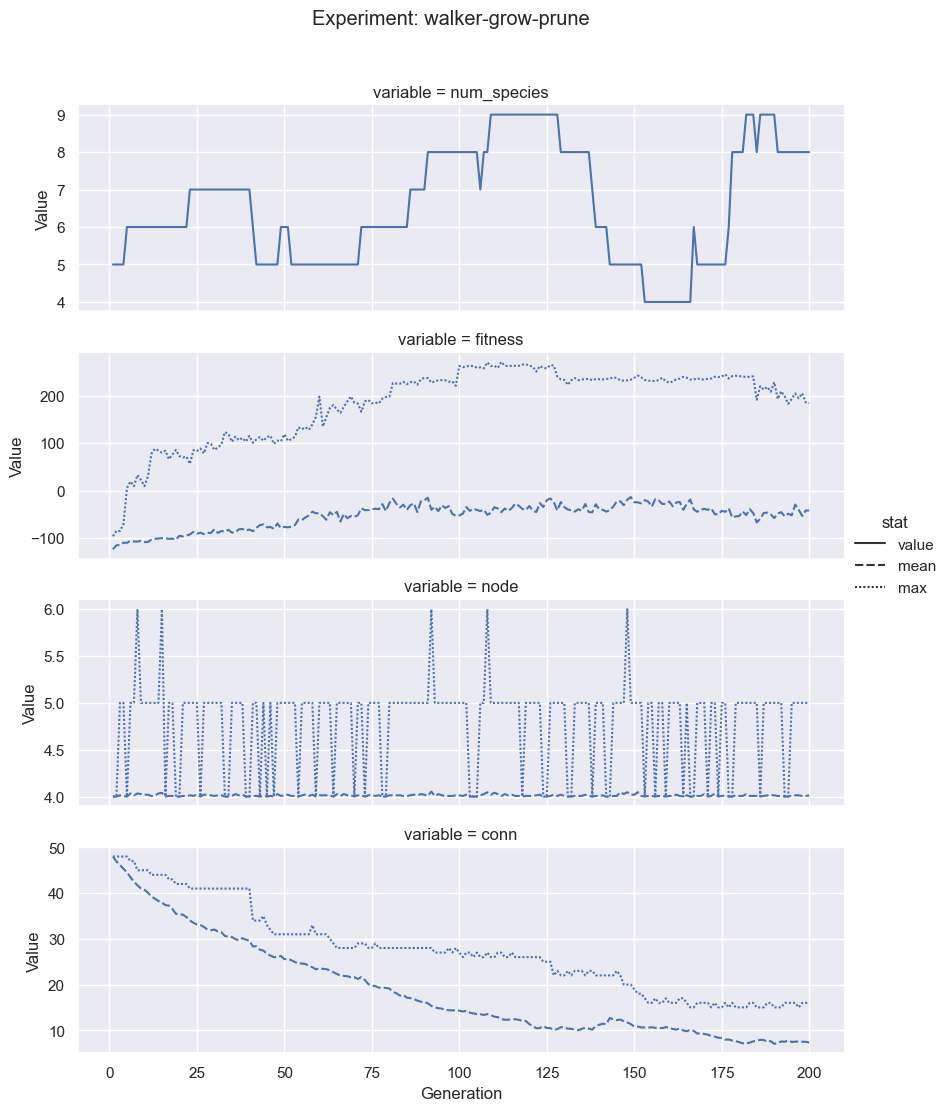

In [177]:
cols_to_plot = ["num_species", "fitness.mean", "fitness.max", "node.mean", "node.max", "conn.mean", "conn.max"]
plot_experiment(experiments, "walker-grow-prune", cols_to_plot)

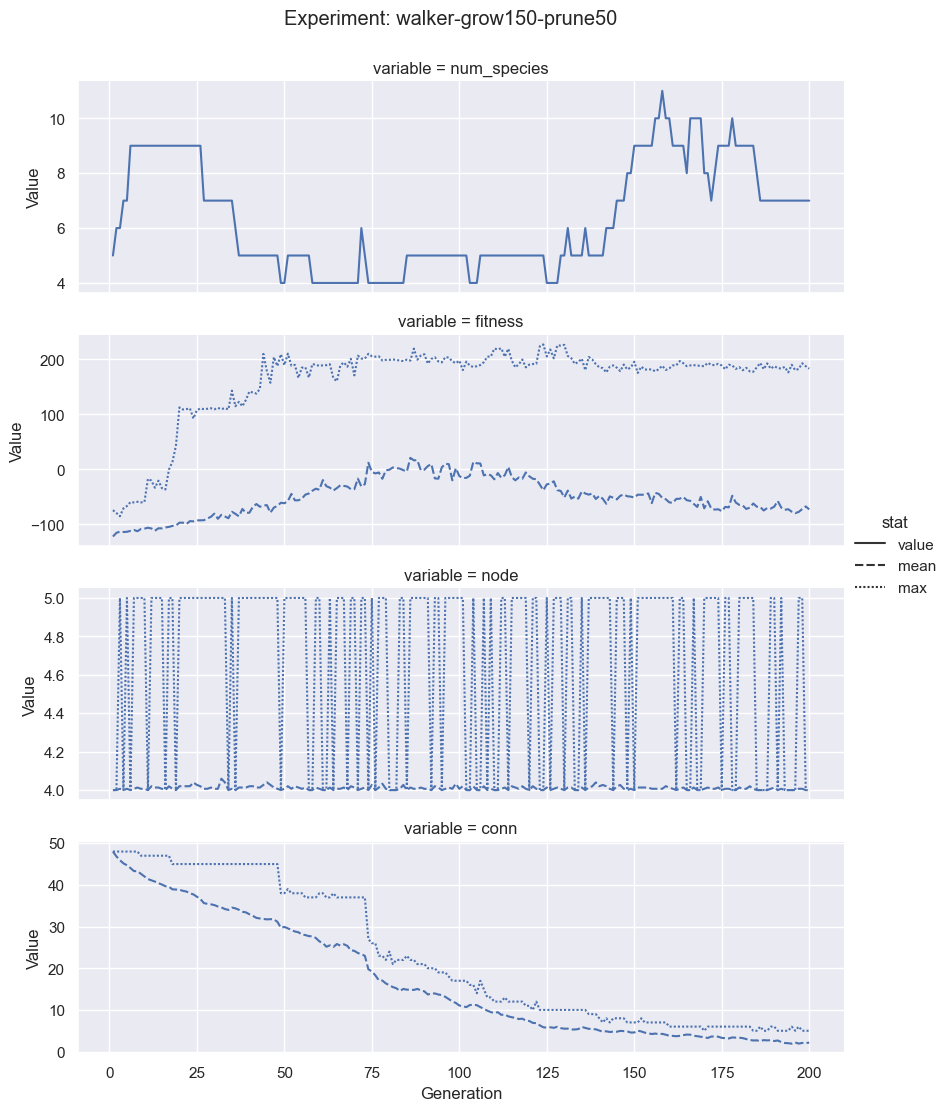

In [190]:
cols_to_plot = ["num_species", "fitness.mean", "fitness.max", "node.mean", "node.max", "conn.mean", "conn.max"]
plot_experiment(experiments, "walker-grow150-prune50", cols_to_plot)

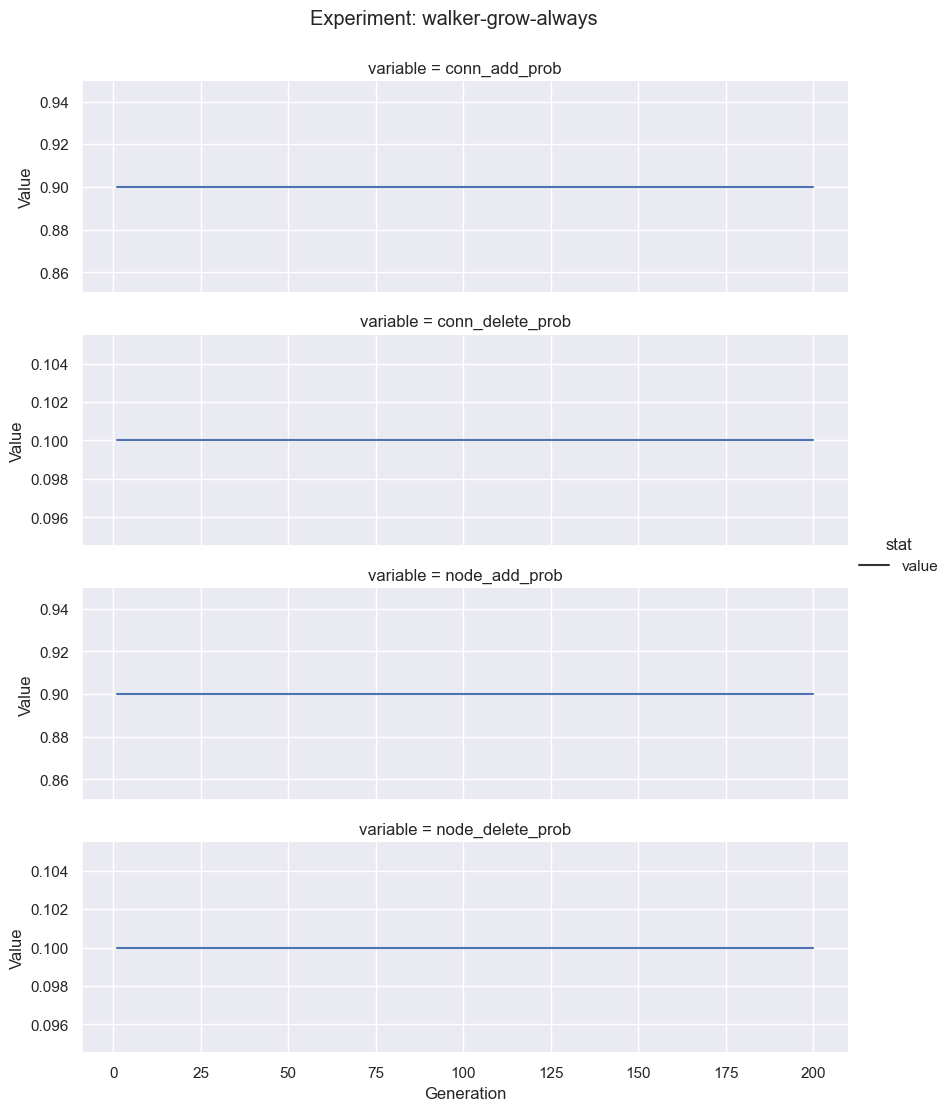

In [193]:
cols_to_plot = ["conn_add_prob", "conn_delete_prob", "node_add_prob", "node_delete_prob"]
plot_experiment(experiments, "walker-grow-always", cols_to_plot)

# Scratch Area

In [127]:
experiments

num_species  best_genome  conn_add_prob  \
experiment     generation                                            
tmp-results    1                   5.0        105.0            0.1   
               2                   5.0        244.0            0.1   
               3                   7.0        105.0            0.1   
               4                   7.0        105.0            0.1   
               5                   7.0        622.0            0.1   
results        0                   NaN          NaN            NaN   
               1                   NaN          NaN            NaN   
               2                   NaN          NaN            NaN   
               3                   NaN          NaN            NaN   
               4                   NaN          NaN            NaN   
configs        1                   5.0          3.0            NaN   
walker-results 1                   5.0         14.0            0.9   
               2                   5.0        240.0            0.9   
               3                   6.0        335.0            0.9   
               4                   6.0        335.0            0.9   
               5                   8.0        335.0            0.9   
               6                   8.0        335.0            0.9   
               7                   9.0        335.0            0.9   
               8                   9.0       1108.0            0.9   

                           conn_delete_prob  node_add_prob  node_delete_prob  \
experiment     generation                                                      
tmp-results    1                        0.1            0.1               0.1   
               2                        0.1            0.1               0.1   
               3                        0.1            0.1               0.1   
               4                        0.1            0.1               0.1   
               5                        0.1            0.1               0.1   
results        0                        NaN            NaN               NaN   
               1                        NaN            NaN               NaN   
               2                        NaN            NaN               NaN   
               3                        NaN            NaN               NaN   
               4                        NaN            NaN               NaN   
configs        1                        NaN            NaN               NaN   
walker-results 1                        0.1            0.9               0.1   
               2                        0.1            0.9               0.1   
               3                        0.1            0.9               0.1   
               4                        0.1            0.9               0.1   
               5                        0.1            0.9               0.1   
               6                        0.1            0.9               0.1   
               7                        0.1            0.9               0.1   
               8                        0.1            0.9               0.1   

                           fitness.count  fitness.mean  fitness.std  \
experiment     generation                                             
tmp-results    1                   150.0   -126.644436    22.253123   
               2                   150.0   -114.993664    18.310690   
               3                   150.0   -111.919092    15.853113   
               4                   151.0   -115.480293    20.399394   
               5                   150.0   -114.542033    21.795910   
results        0                   150.0   -124.877402    25.154211   
               1                   151.0   -117.279166    21.422543   
               2                   151.0   -114.933896    21.538975   
               3                   152.0   -111.885640    17.755780   
               4                   152.0   -113.792162    24.119416   
configs        1       